In [1]:
import numpy as np
import pandas as pd
import statsmodels.tsa.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import datetime
import os
warnings.filterwarnings("ignore")

def tsplot(y, lags=50, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))    
        y.plot(ax=ts_ax)
        p_value = sm.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        sm.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        sm.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        plt.tight_layout()
    return

def write_results(file_name, results, columns):
    with open(file_name,"w") as fw:
        print(results.summary(), file=fw)
        fw.write("================test_whiteness================\n")
        print(results.test_whiteness(nlags=20), file=fw)
        fw.write("================results.roots()================\n")
        for root in results.roots:
            fw.write(str(root)+",")
        fw.write("\n================is_stable================\n")
        fw.write(str(results.is_stable()))
        fw.write("\n================granger causality================\n")
        for V1 in columns:
            for V2 in columns:
                fw.write("Granger test: "+V2+"-->"+V1+"\n")
                print(results.test_causality(V1, [V2],kind='f').summary(), file=fw)
                fw.write("\n")

        fw.write("\n================long_run effects================\n")
        for effect in results.long_run_effects():
            fw.write(str(effect)+",")
        fw.write("\n================FEVD values================\n")
        from contextlib import redirect_stdout
        with redirect_stdout(fw):
            print(results.fevd(20).summary())

def structural_analyses(file_name, results, lag=20):
    # impulse response analyses
    irf = results.irf(lag)
    irf.plot(orth=False)
    plt.savefig(file_name+"_irf_noorth.png")
    # irf.plot(impulse='V1', response="V2")
    irf.plot_cum_effects(orth=False)
    plt.savefig(file_name+"_irf_cum_noorth.png")
    results.long_run_effects()

    # forecast error decomposition
    results.fevd(lag).plot()
    plt.savefig(file_name+"_fevd.png")
    

In [2]:
# read csv file    
df = pd.read_csv("data.csv")
# convert to date format
df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%d").dt.date

# drop first 6 rows to be able to divide by 7 (starts on Sunday)
df = df.iloc[6:]
df.index = pd.to_datetime(df['date'])
df.drop(['Unnamed: 0', 'date'], axis=1, inplace=True)
df = df.resample('7D').mean()

# set date as index
print(df)

                   USD           BTC          ETH       XLM      USDT  \
date                                                                    
2017-04-09  100.767141   1184.245728    46.184528  0.002989  0.999690   
2017-04-16   99.977143   1211.664289    48.926500  0.003559  0.988751   
2017-04-23   99.147144   1279.989990    57.405158  0.004069  0.924279   
2017-04-30   98.920001   1483.474278    85.927657  0.008408  0.944119   
2017-05-07   99.311429   1748.609985    90.783716  0.036769  0.974597   
...                ...           ...          ...       ...       ...   
2021-02-28   91.328572  48583.871094  1539.878488  0.414477  1.000721   
2021-03-07   91.831428  55809.454241  1821.154227  0.410833  1.000388   
2021-03-14   91.781429  57914.933036  1812.828805  0.398707  1.000728   
2021-03-21   92.429998  54625.823104  1680.901507  0.386942  1.001204   
2021-03-28   93.030573  58496.472097  1927.556728  0.421905  1.000511   

                NANO  
date                  
2017

                   USD           BTC       XLM
date                                          
2017-04-09  100.767141   1184.245728  0.002989
2017-04-16   99.977143   1211.664289  0.003559
2017-04-23   99.147144   1279.989990  0.004069
2017-04-30   98.920001   1483.474278  0.008408
2017-05-07   99.311429   1748.609985  0.036769
...                ...           ...       ...
2021-02-28   91.328572  48583.871094  0.414477
2021-03-07   91.831428  55809.454241  0.410833
2021-03-14   91.781429  57914.933036  0.398707
2021-03-21   92.429998  54625.823104  0.386942
2021-03-28   93.030573  58496.472097  0.421905

[208 rows x 3 columns]


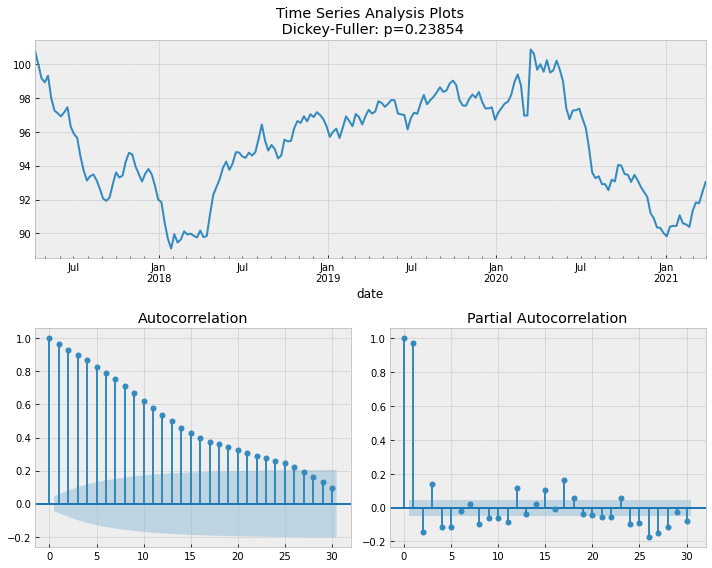

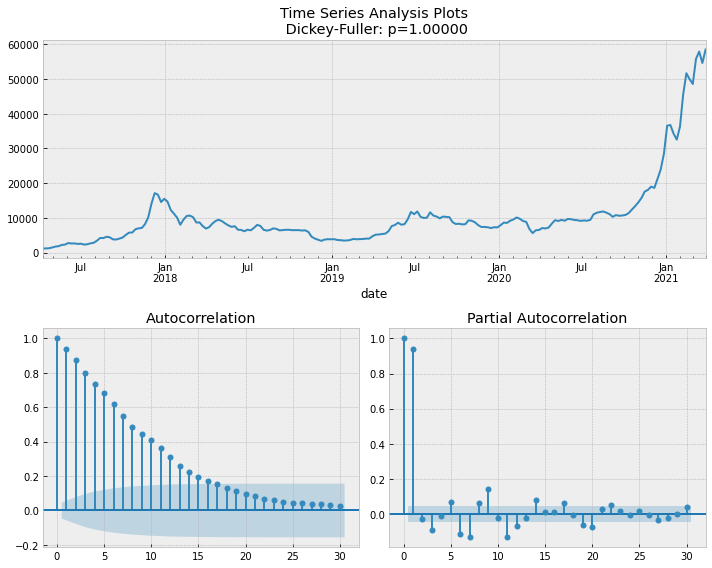

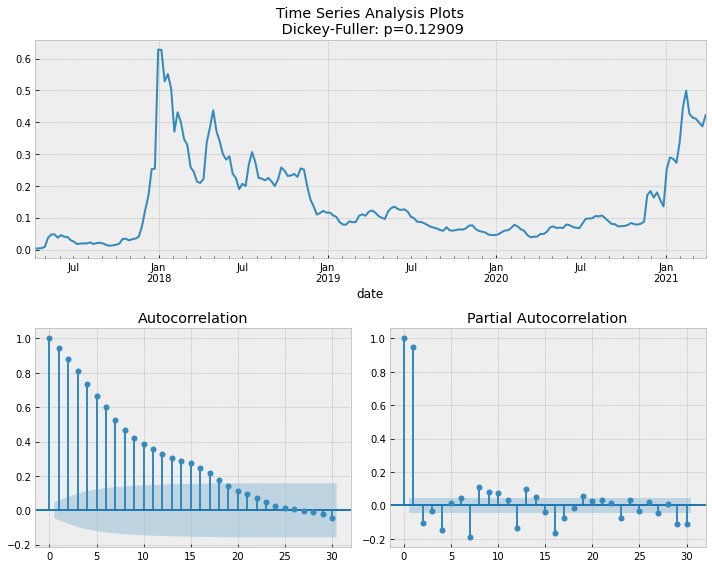

In [4]:
# Nano Case
id = 'stella_weekly'
data = df.drop(['USDT', 'ETH','NANO'], axis=1, inplace = False)
print(data)

focused_columns = ["USD", "BTC", "XLM"]

if not os.path.exists(id):
    os.makedirs(id)

# see original plots of all products
for column in focused_columns:
    tsplot(data[column], lags = 30)
    plt.savefig(str(id)+'/tsplot_'+column+'.png')
    plt.show()
    plt.close()

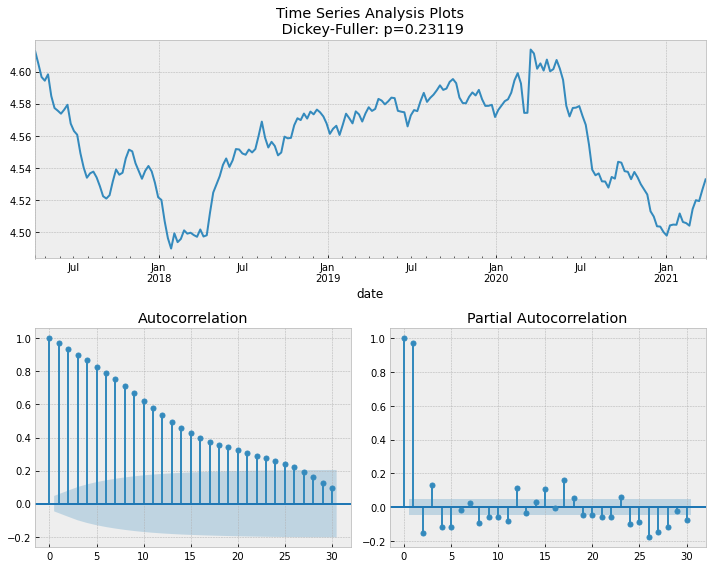

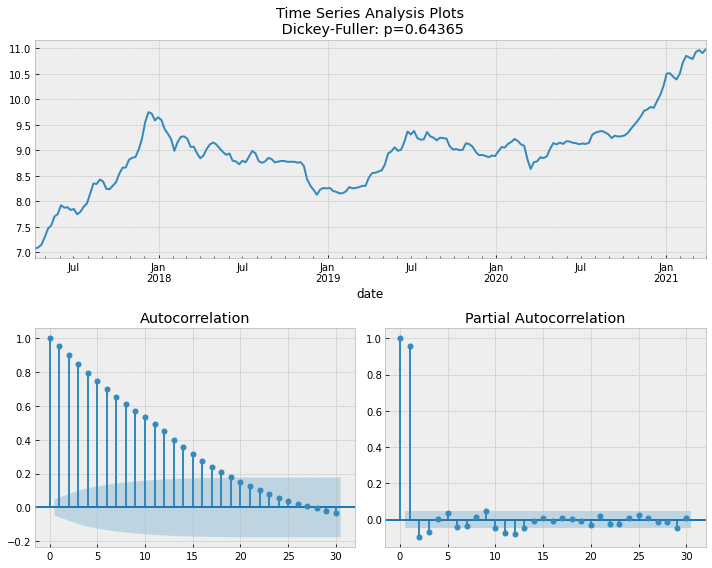

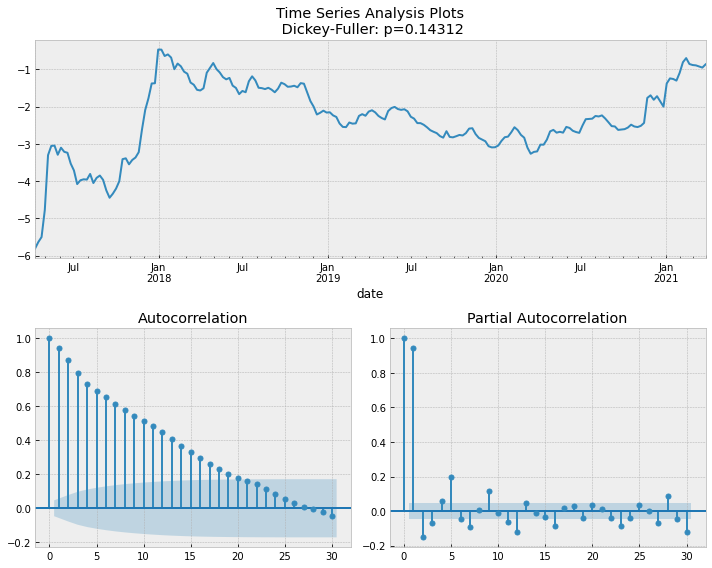

In [5]:
# log transformation
data_log = data.copy()
for column in focused_columns:
    data_log[column] = np.log(data[column]) 
    tsplot(data_log[column], lags = 30)
    plt.savefig(str(id)+'/tsplot_log_'+column+'.png')
    plt.show()
    plt.close()


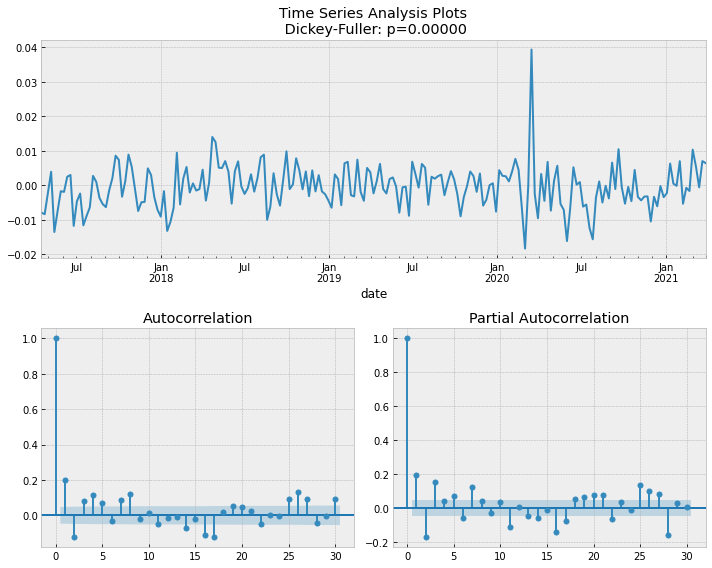

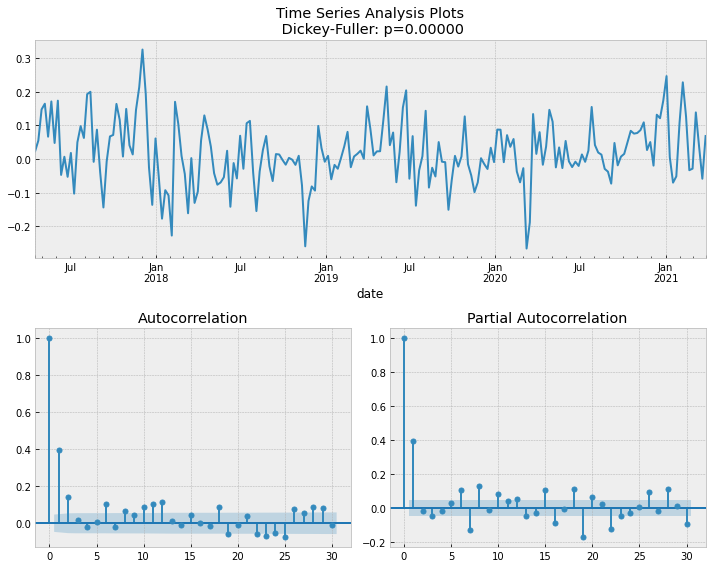

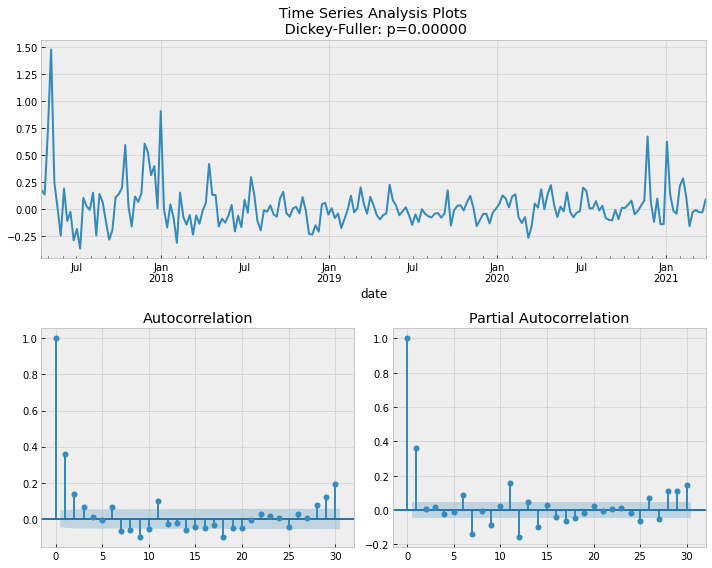

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -18.95      -18.90   5.869e-09      -18.93
1       -19.19     -18.98*   4.645e-09     -19.10*
2      -19.22*      -18.85  4.517e-09*      -19.07
3       -19.18      -18.67   4.661e-09      -18.97
4       -19.13      -18.45   4.938e-09      -18.85
5       -19.08      -18.25   5.176e-09      -18.74
6       -19.06      -18.08   5.286e-09      -18.66
7       -19.03      -17.89   5.444e-09      -18.57
8       -18.98      -17.69   5.729e-09      -18.46
9       -18.96      -17.51   5.846e-09      -18.38
10      -18.93      -17.33   6.042e-09      -18.28
11      -18.99      -17.22   5.754e-09      -18.27
12      -18.92      -17.01   6.139e-09      -18.15
13      -18.87      -16.80   6.495e-09      -18.03
14      -18.79      -16.56   7.072e-09      -17.89
15      -18.73      -16.35   7.540e-09      -17.77
16      -18.69      -16.15   7.

In [6]:
# first order differencing
data_diff = data_log.diff().dropna()
for column in focused_columns:
    tsplot(data_diff[column], lags = 30)
    plt.savefig(str(id)+'/tsplot_diff_'+column+'.png')
    plt.show()
    plt.close()

# modelling using VAR for analysis
model = VAR(data_diff.dropna())
print(model.select_order(20).summary())
selected_orders = model.select_order(20).selected_orders
print(selected_orders)

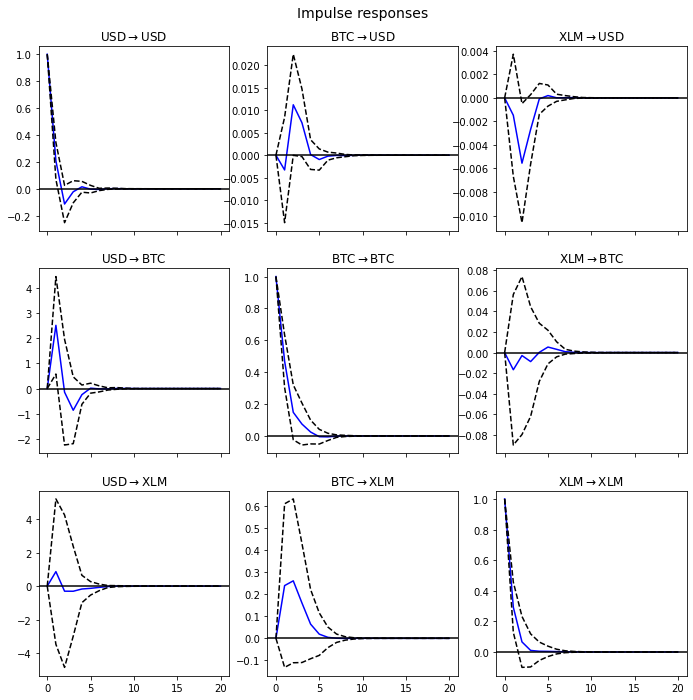

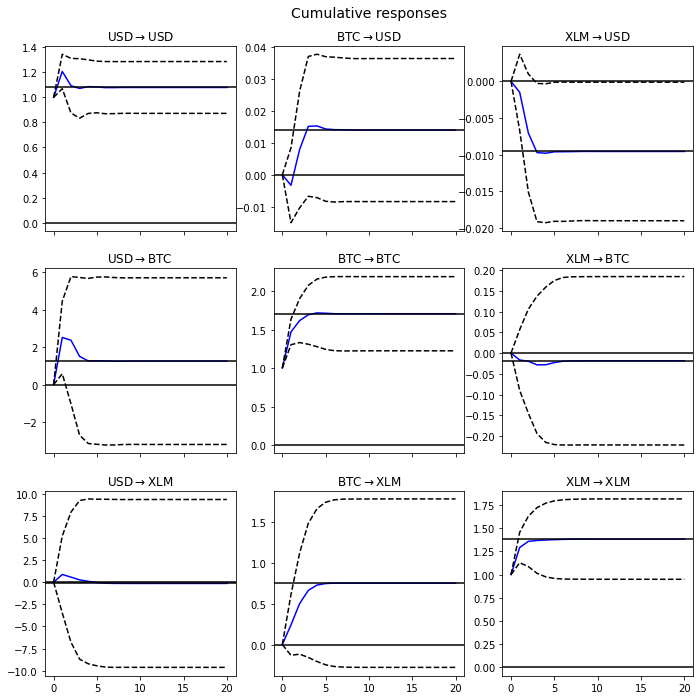

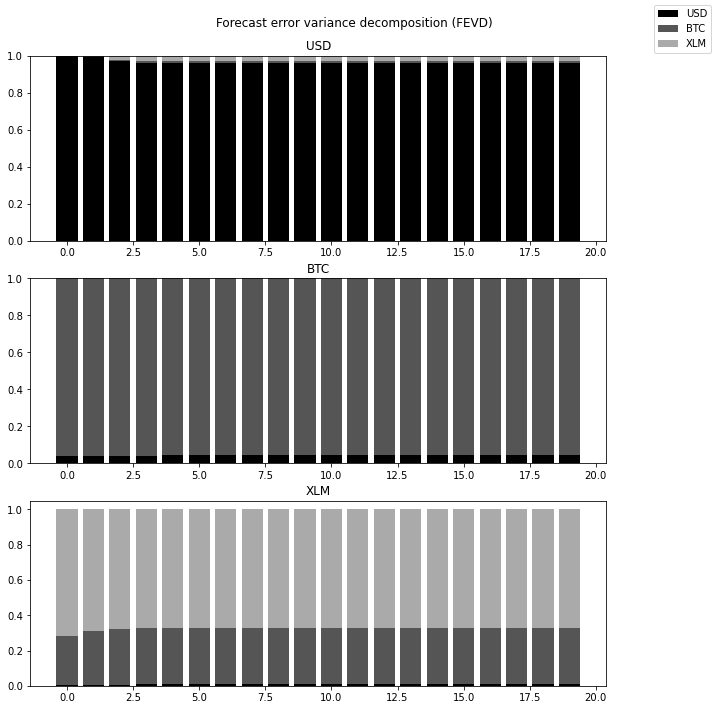

In [9]:
# order 2 is the best lag order
order = 2
results = model.fit(order, trend="c")
results_file = f"{id}/results_lag{order}.txt" 
structural_file = f"{id}/lag{order}"
columns = data.columns.values.tolist()
write_results(results_file, results, columns)
structural_analyses(structural_file, results, 20)